링크 : https://wikidocs.net/44249

In [64]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [65]:
pip install konlpy

In [66]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [67]:
# 데이터 로드 
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f03b66aa310>)

In [68]:
# 훈련데이터와 테스트데이터 판다스로 변경
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [69]:
# 훈련데이터와 테스트데이터 판다스로 변경
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

print('훈련용 리뷰 개수 :',len(train_data))

훈련용 리뷰 개수 : 150000


In [70]:
train_data[:2]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1


In [71]:
test_data[:2]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0


In [72]:
# 훈련데이터 정재

# 중복 체크
train_data['document'].nunique(), train_data['label'].nunique()

# 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

# 중복 제거된 데이터 확인
print('중복 제거한 총 샘플의 수 :',len(train_data))

중복 제거한 총 샘플의 수 : 146183


   label  count
0      0  73342
1      1  72841


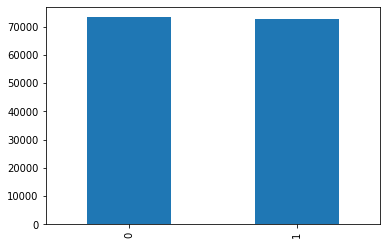

In [73]:
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [74]:
# Null 값 유무 확인
print(train_data.isnull().values.any())

# Null 값을 가진 컬럼 확인
print(train_data.isnull().sum())

# Null 값을 가진 인덱스 확인
train_data.loc[train_data.document.isnull()]

# Null 값이 존재하는 행 제거
train_data = train_data.dropna(how = 'any') 

# Null 값 제거 후 총 샘플 수 확인
print(len(train_data))

True
id          0
document    1
label       0
dtype: int64
146182


In [75]:
# 한글과 공백을 제외하고 모두 제거
# ㄱ~ㅎ,ㅏ~ㅣ,가-힣, 
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:2]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1


In [76]:
# 한글과 공백을 제외하고 모두 제거한 후 생겨난 Null 값이 있는지 확인
train_data['document'] = train_data['document'].str.replace('^ +', "") 
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [77]:
# Null 값이 있는 테이블 확인
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [78]:
# Null 값이 있는 테이블 다시 제거
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [79]:
# 테스트 데이터 정재

# document 열에서 중복인 내용이 있다면 중복 제거
test_data.drop_duplicates(subset = ['document'], inplace=True) 

# 한글과 공백을 제외하고 모두 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

# 공백은 empty 값으로 변경
test_data['document'] = test_data['document'].str.replace('^ +', "") 

# 공백은 Null 값으로 변경
test_data['document'].replace('', np.nan, inplace=True)

# Null 값 제거
test_data = test_data.dropna(how='any') 
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


In [80]:
# 토큰화

# 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석 테스트
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [81]:
# 훈련데이터 토큰화

X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] 
    X_train.append(stopwords_removed_sentence)

  9%|▉         | 13256/145393 [00:55<09:13, 238.61it/s]


KeyboardInterrupt: ignored

In [ ]:
# 테스트데이터 토큰화

X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) 
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] 
    X_test.append(stopwords_removed_sentence)

In [82]:
print('전처리 후 테스트용 샘플의 개수 :',len(X_test))

전처리 후 테스트용 샘플의 개수 : 48852


In [83]:
# 정수 인코딩

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index)
print(tokenizer.word_counts.items())

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '만': 11, '재밌다': 12, '적': 13, '되다': 14, '같다': 15, '진짜': 16, '아니다': 17, '로': 18, '점': 19, '않다': 20, '에서': 21, '만들다': 22, '연기': 23, '나오다': 24, '평점': 25, '것': 26, '안': 27, '최고': 28, '인': 29, '내': 30, '나': 31, '못': 32, '그': 33, '스토리': 34, '드라마': 35, '왜': 36, '사람': 37, '보고': 38, '생각': 39, '감동': 40, '게': 41, '이렇다': 42, '고': 43, '아깝다': 44, '감독': 45, '때': 46, '더': 47, 'ㅋㅋ': 48, '그냥': 49, '말': 50, '시간': 51, '배우': 52, '재미': 53, '거': 54, '아': 55, '요': 56, '재미없다': 57, '재미있다': 58, '내용': 59, '지루하다': 60, '까지': 61, '하고': 62, '중': 63, '자다': 64, '뭐': 65, '네': 66, '주다': 67, '가다': 68, '작품': 69, '모르다': 70, '쓰레기': 71, '수': 72, '들다': 73, '알다': 74, '지': 75, '하나': 76, '그렇다': 77, '싶다': 78, '사랑': 79, '정도': 80, '이건': 81, '다시': 82, '볼': 83, '이렇게': 84, '액션': 85, '마지막': 86, '최악': 87, 'ㅋ': 88, '저': 89, '개': 90, 'ㅠㅠ': 91, '느낌': 92, '완전': 93, '기': 94, '연출': 95, '돈': 96, '주인공': 97, '걸': 98, '차다': 99, 'ㅋㅋㅋ': 100, '처음': 101, '역시': 102

In [84]:
threshold = 3

# 단어의 수
total_cnt = len(tokenizer.word_index) 

# 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
rare_cnt = 0 

# 훈련 데이터의 전체 단어 빈도수 총 합
total_freq = 0

# 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
rare_freq = 0 

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 14245
등장 빈도가 2번 이하인 희귀 단어의 수: 9140
단어 집합에서 희귀 단어의 비율: 64.16286416286417
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.70079268835769


In [92]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 5106


In [94]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

NameError: ignored

In [95]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [96]:
print(len(X_train))
print(len(y_train))

13256
145393


In [97]:
print(X_train[:3])

[[55, 635, 16, 274, 819], [721, 355, 38, 636, 1, 167, 1517, 23, 849, 722, 20], [366, 1877, 2031, 3972, 2, 218, 9]]


In [98]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [99]:
print(drop_train)

[28, 169, 398, 414, 546, 1091, 1149, 1347, 1484, 1572, 1711, 1940, 1957, 2201, 2321, 2345, 2432, 3233, 3273, 3439, 3440, 4155, 4289, 4612, 4809, 4857, 5021, 5722, 6408, 6418, 7141, 7149, 7273, 7342, 7790, 8295, 8343, 8677, 8931, 9343, 9660, 9718, 9884, 10352, 10596, 10815, 10973, 11136, 11669, 11897, 12020, 12456, 12504, 12531, 12714, 12716, 12722, 12766, 12896, 12993]


In [100]:
len(drop_train)

60

In [101]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [102]:
print(len(X_train))
print(len(y_train))

13196
145333


In [103]:
print(len(X_test))
print(len(y_test))

48852
48852


In [104]:
X_test = np.delete(X_test, drop_test, axis=0)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [105]:
y_test = np.delete(y_test, drop_test, axis=0)

In [106]:
print(len(X_test))
print(len(y_test))

48745
48745


리뷰의 최대 길이 : 54
리뷰의 평균 길이 : 10.209078508638981


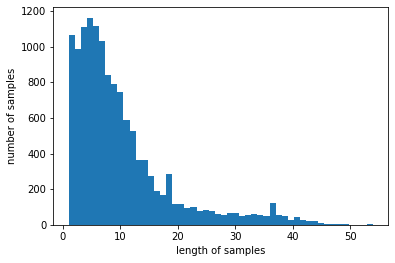

In [107]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [108]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [109]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 95.02879660503183


In [110]:
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [111]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [112]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [113]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [114]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
165/165 [==============================] - 11s 19ms/step - loss: 0.5155 - acc: 0.7426 - val_loss: 0.4232 - val_acc: 0.7981

Epoch 00001: val_acc improved from -inf to 0.79811, saving model to best_model.h5
Epoch 2/15
165/165 [==============================] - 2s 14ms/step - loss: 0.3520 - acc: 0.8485 - val_loss: 0.4737 - val_acc: 0.7924

Epoch 00002: val_acc did not improve from 0.79811
Epoch 3/15
165/165 [==============================] - 2s 14ms/step - loss: 0.3065 - acc: 0.8698 - val_loss: 0.4129 - val_acc: 0.8155

Epoch 00003: val_acc improved from 0.79811 to 0.81553, saving model to best_model.h5
Epoch 4/15
165/165 [==============================] - 2s 14ms/step - loss: 0.2806 - acc: 0.8812 - val_loss: 0.4345 - val_acc: 0.8121

Epoch 00004: val_acc did not improve from 0.81553
Epoch 5/15
165/165 [==============================] - 2s 14ms/step - loss: 0.2629 - acc: 0.8903 - val_loss: 0.4427 - val_acc: 0.8144

Epoch 00005: val_acc did not improve from 0.81553
Epoch 6/15
1

In [115]:
loaded_model = load_model('best_model.h5')

In [116]:
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1524/1524 [==============================] - 8s 5ms/step - loss: 1.0539 - acc: 0.5733

 테스트 정확도: 0.5733


In [117]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [118]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

51.31% 확률로 긍정 리뷰입니다.



In [119]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

51.31% 확률로 긍정 리뷰입니다.



In [120]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

51.31% 확률로 긍정 리뷰입니다.



In [121]:
sentiment_predict('감독 뭐하는 놈이냐?')

51.31% 확률로 긍정 리뷰입니다.



In [122]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

51.31% 확률로 긍정 리뷰입니다.

